This example is based on the material from the coursera course of The Imperial College on london for Tensorflow 2 availabel at https://www.coursera.org/learn/getting-started-with-tensor-flow2

# Convolutional Neural Networks using Keras

In this notebook, we'll look at some of the basic elements needed to build a convolutional neural network using Keras.

As always, we'll start by importing some needed libraries. If your are running this in Colab, it is highly advisable that you switch to a GPU or TPU backend.

In [11]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#matplotlib inline

The inspiration behind Convolution Neural Networks goes back to the "traditional" Computer Vision methods for image processing. In CV, typically, researchers would chose a collection of filters to extract relevant features from images previous to training a machine learning model. For insance, we could apply simple vertical and horizontal filter s to a sample image.

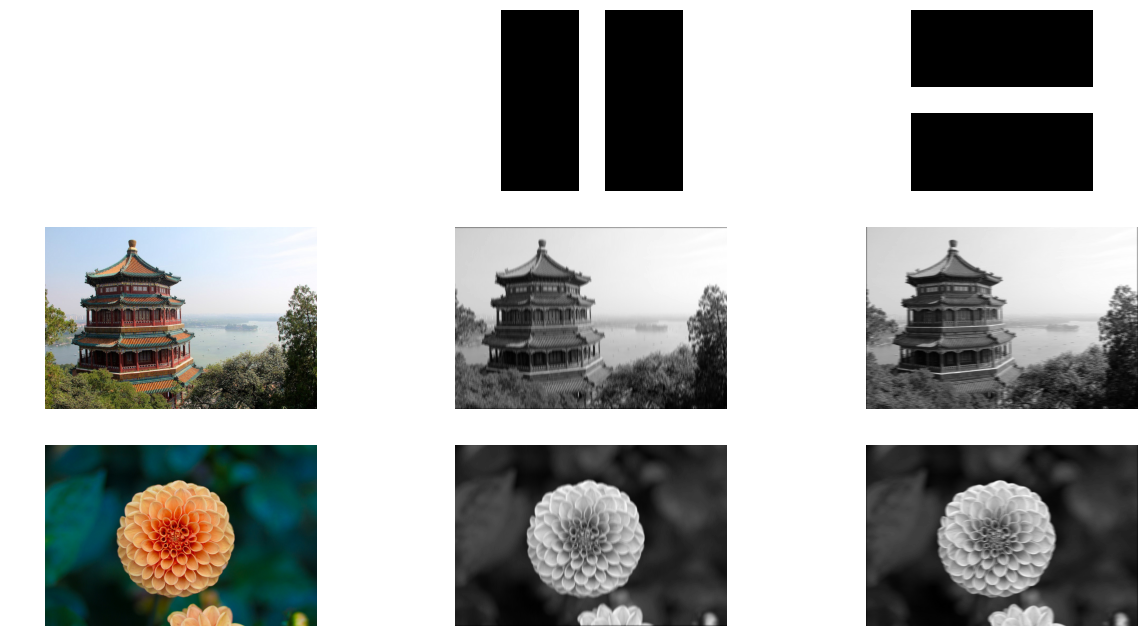

In [12]:
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

figure, axis = plt.subplots(3, 3)

figure.set_figwidth(15)
figure.set_figheight(8)

for i in range(3):
  for j in range(3):
    axis[i,j].axis('off')

axis[1,0].imshow(china)
axis[2,0].imshow(flower)

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Show filters
axis[0,1].imshow(filters[:, :, 0, 0], cmap="gray")
axis[0,2].imshow(filters[:, :, 0, 1], cmap="gray")

# Apply convolution
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

# Show feature map
axis[1,1].imshow(outputs[0, :, :, 0], cmap="gray") # plot 1st image's 1st feature map
axis[1,2].imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map

axis[2,1].imshow(outputs[1, :, :, 0], cmap="gray") # plot 2nd image's 1st feature map
axis[2,2].imshow(outputs[1, :, :, 1], cmap="gray") # plot 2nd image's 2nd feature map

plt.show()

## Convolution Layers

Of course, when working with Keras to build a CNN, we do not need to define our filters manually, nor apply the convolution operations "manually". Instead we can simply use `keras.layers.Conv2D` to define a convolution layer that can be trained as part of a CNN.

```python
keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")
```
In the above example we define a convolution layer with 32 learnable filters, each of size $3\times3\times channels$, with a stride of 1 and using `same` (zero) padding (alternatively, we could use `"valid"` if we don't want to use padding).

Take a minute to check the [Conv2D documentation](https://keras.io/api/layers/convolution_layers/convolution2d/).


## Pooling Layers

Typical CNN architectures pair `Conv2D` with pooling layers in order to reduce the feature maps' dimensiones while increasing the feature volume's depth. To define a pooling layer we can use keras' `keras.layers.MaxPool2D` or `keras.layers.AvgPool2D`.

```python
keras.layers.MaxPool2D(pool_size=2)
```

In the above example, the stride defaults to the kernel size.

You can read more in the corresponding documentation: [MaxPool2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) and [AvgPool2D](https://keras.io/api/layers/pooling_layers/average_pooling2d/)


## Loading and preprocessing the data

For this example, we'll work with the [`fashion_mnist`](https://keras.io/api/datasets/fashion_mnist/) dataset. This is a dataset of 60,000 $28\times28$ grayscale images of 10 fashion categories, along with a test set of 10,000 images.

In [13]:
# Load the Fashion-MNIST dataset
fashion_mnist_data = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist_data.load_data()

In [14]:
# Print the shape of the training data
print(train_images.shape)
print(train_labels.shape)
print(train_labels) # Labels are numbers between 0 and 9

(60000, 28, 28)
(60000,)
[9 0 0 ... 3 0 5]


In [15]:
# One-hot encode targets
from tensorflow import keras
from keras.utils import to_categorical #type: ignore

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [16]:
train_labels.shape

(60000, 10)

In [17]:
# Define the labels for easier interpretation
labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

In [18]:
# Rescale the image values so that they lie in between 0 and 1.
train_images = train_images/255.0
test_images = test_images/255.0

# Add an extra dimension (channel) to images
# Needed since Conv2D layers expect images to be tridimensional
train_images = train_images[...,np.newaxis]
test_images = test_images[...,np.newaxis]
train_images.shape

(60000, 28, 28, 1)

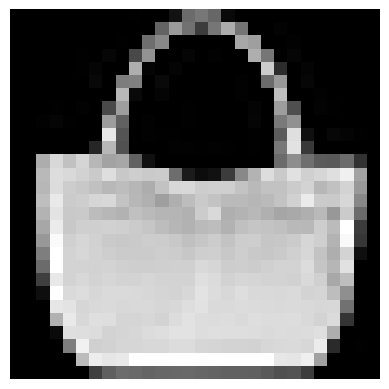

label : Bag


In [19]:
# Display one of the images
img_num = 100 # change this number to visualize other images in the set
plt.axis('off')
plt.imshow(train_images[img_num][:,:,0], cmap='gray')
plt.show()
print(f"label : {labels[np.argmax(train_labels[img_num])]}")

## Building a convolutional neural network model

Next we'll build our model. For this example, we'll go with a basic architecture, consisting of `Conv2D` followed by `MaxPooling2D` blocks. Notice we'll increase the number of feature maps, as we decrease their size.

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

In [21]:
model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(16, kernel_size=3, padding='same', activation="relu"),
    MaxPooling2D(2),
    Conv2D(32, kernel_size=3, padding='same', activation="relu"),
    MaxPooling2D(2),
    Flatten(),
    Dense(10, activation='softmax')
])

Things to consider:
- The first `Conv2D` layer's input shape needs to match our data set. In this case, we'll use $28\times28$ grayscale images hence [28, 28, 1]. Notice how we don't need to flatten the input just yet.
- We're using the `relu` activation function for each of the convolution layers.
- Each layer has a kernel of $3\times3$.
- All `Conv2D` layers use a default stride of 1 and zero-padding, thus producing feature maps of the same size as their inputs.
- Pooling layers use a kernel of size $2\times2$ (and stride of size 2), thus dividing each spatial dimension by a factor of 2.
- The `Flatten` layer marks the "end" of the feature selection part of our CNN and the start of the classification.
- We define a 10 neuron `Dense` layer with a `softmax` activiation function as the last layer of our model since our dataset contains 10 exclusive classes.

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        15,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,490 (80.04 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

## The compile method

Once the model is built, we can `compile` it. We'll use the `Adam` optimizer with a `learning_rate` of 0.0005. Additionally, we'll keep track of the model's accuracy and mean absolute error.

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=.0005)
acc = tf.keras.metrics.CategoricalAccuracy()

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[acc])

## The fit method

We are now ready to train the model. Remember you can re-run the `fit` method if you want to continue training the model for extra epochs, and the training process will pick up where it left off.

In [24]:
history = model.fit(x=train_images, y=train_labels, validation_split=0.1, batch_size=128, epochs=15)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - categorical_accuracy: 0.6340 - loss: 1.0999 - val_categorical_accuracy: 0.8058 - val_loss: 0.5077
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8359 - loss: 0.4637 - val_categorical_accuracy: 0.8522 - val_loss: 0.4258
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - categorical_accuracy: 0.8556 - loss: 0.4069 - val_categorical_accuracy: 0.8603 - val_loss: 0.3901
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - categorical_accuracy: 0.8672 - loss: 0.3760 - val_categorical_accuracy: 0.8690 - val_loss: 0.3698
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8746 - loss: 0.3550 - val_categorical_accuracy: 0.8768 - val_loss: 0.3473
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - categorical_accuracy: 0.8800 - loss: 0.3425 - val_categorical_accuracy: 0.8800 - val_loss: 0.3380
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - categorical_accuracy: 0.885

## Plot training history

It's usually a good idea to review our training results. We can use the history returned by the `fit` method for this purpose.

In [25]:
# Load the history into a pandas Dataframe
df = pd.DataFrame(history.history)
df

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0.749611,0.730783,0.805833,0.507663
1,0.841778,0.449145,0.852167,0.425785
2,0.857796,0.401589,0.860333,0.390088
3,0.868481,0.372299,0.869000,0.369760
4,0.875444,0.353142,0.876833,0.347306
5,0.881222,0.337652,0.880000,0.338005
6,0.886296,0.323011,0.885167,0.325872
7,0.890611,0.313201,0.885333,0.325617
8,0.893019,0.303988,0.885167,0.313759
9,0.896759,0.295255,0.891000,0.310971


<Axes: title={'center': 'Loss vs Epoch'}>

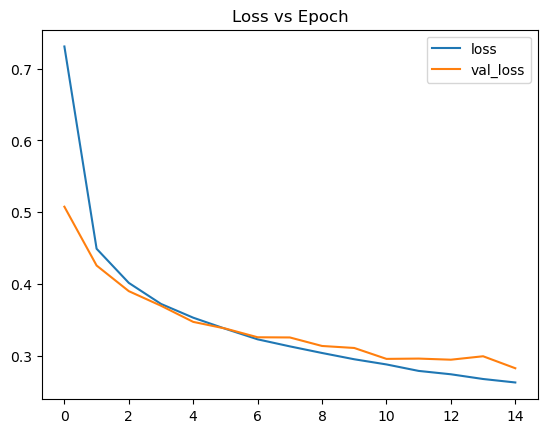

In [26]:
# Make a plot for the loss
df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

<Axes: title={'center': 'Categorical_accuracy vs Epoch'}>

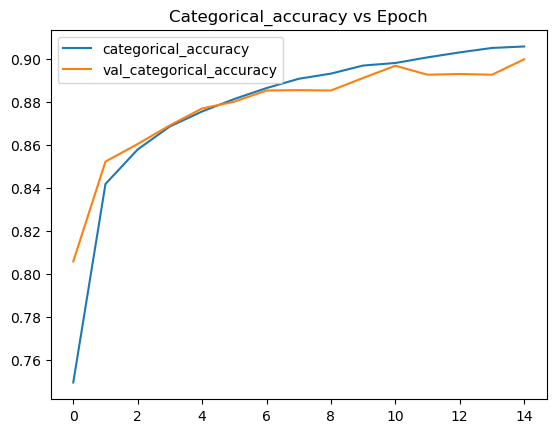

In [27]:
# Make a plot for the accuracy
df.plot(y=["categorical_accuracy", "val_categorical_accuracy"], title="Categorical_accuracy vs Epoch")

## The evaluate and predict methods

Finally, we can evaluate the model's performance using the test set.

#### Evaluate the model on the test set

In [28]:
print(test_images.shape)

(10000, 28, 28, 1)


In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.8957 - loss: 0.3035
Loss: 0.31
Accuracy: 0.89


#### Make predictions from the model

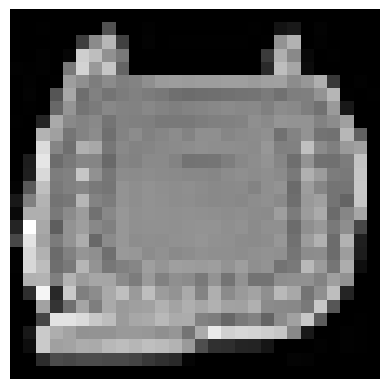

Label: Bag


In [30]:
# Choose a random test image
random_inx = np.random.choice(test_images.shape[0])
test_image = test_images[random_inx]

plt.axis('off')
plt.imshow(test_image[:,:,0], cmap='gray')
plt.show()
print(f"Label: {labels[np.argmax(test_labels[random_inx])]}")

In [31]:
# Get the model predictions
pred = model.predict(test_image[np.newaxis,...])
print("Model: ", labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Model:  Bag


In [32]:
# Check model's predictions for each possible class
df = pd.DataFrame(pred, columns=labels)
df

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.001731,0.000471,0.001404,0.000541,0.000029,3.856759e-09,0.042235,0.000002,0.953585,0.000003


<Axes: >

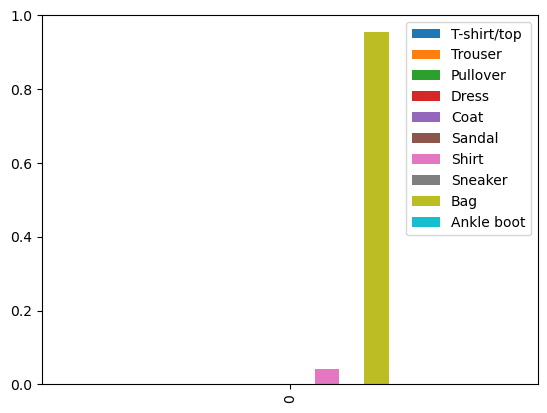

In [33]:
# Visualize model's predictions
df.plot.bar()